In [1]:
allure_etudier=1

In [34]:
import  sys

#LOCALISATION DES DONNEES
sys.path.insert(0, "C:/projets_python/diabolo")

import warnings
warnings.filterwarnings("ignore")



#LIBRAIRIES PERSO
import etude_variable.MyLog as log
import etude_variable.jouer as jouer
import etude_variable.lecture_data as ld
import etude_variable.analyse as ana

# LIBRAIRIE PYHTON CLASSIQUES
import pandas as pd
import numpy as np
import matplotlib
import scipy
import platform

from collections import Counter

#ESTIMATEUR
import sklearn
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.ensemble import  RandomForestClassifier
from sklearn import neighbors, datasets
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Imputer

from sklearn.ensemble import GradientBoostingClassifier

from sklearn.svm import SVC, LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import scale

from sklearn.naive_bayes import GaussianNB
from sklearn.calibration import calibration_curve



from scipy.stats import uniform
from scipy.stats import randint

#TRAINING
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from skopt import BayesSearchCV
import dask_searchcv as dcv
from skopt.space import Real, Integer
from sklearn.model_selection import cross_validate

#Evaluateur
from sklearn.model_selection import KFold

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold

from sklearn.feature_selection import SelectFromModel


from evolutionary_search import EvolutionaryAlgorithmSearchCV
from sklearn.utils import class_weight

#outils
from dask.diagnostics import ProgressBar
import logging
from datetime import datetime


#Metriques
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import learning_curve
from sklearn import  metrics
from sklearn.metrics import  roc_auc_score
from sklearn.metrics import  classification_report

#Outils

import time


#Graphique
from matplotlib import pyplot
from matplotlib import pyplot as plt
import seaborn as sns

print('Operating system version....', platform.platform())
print("Python version is........... %s.%s.%s" % sys.version_info[:3])
print('scikit-learn version is.....', sklearn.__version__)
print('pandas version is...........', pd.__version__)
print('numpy version is............', np.__version__)
print('matplotlib version is.......', matplotlib.__version__)
print('scipy version is.......', scipy.__version__)


Operating system version.... Windows-10-10.0.17134-SP0
Python version is........... 3.6.5
scikit-learn version is..... 0.19.1
pandas version is........... 0.22.0
numpy version is............ 1.14.2
matplotlib version is....... 2.2.0
scipy version is....... 1.0.0


# LECTURE DES DONNEES

In [ ]:
def timer(start_time=None):
    if not start_time:
        start_time = datetime.now()
        print(start_time)
        return start_time
    elif start_time:
        thour, temp_sec = divmod((datetime.now() - start_time).total_seconds(), 3600)
        tmin, tsec = divmod(temp_sec, 60)
        print('\n Time taken: %i hours %i minutes and %s seconds.' % (thour, tmin, round(tsec, 2)))
        
        
def explo_variable(dataset, svariable):

     # On calcule le quantile 0,25 qui est le quartile Q1
    mediane = np.median(dataset)
    print ("La mediane              "+svariable+"    : ", round(mediane, 2))

    maxx = np.max(dataset)
    print ("Le max              "+svariable+"    : ", round(maxx, 2))
    
    minn = np.min(dataset)
    print ("Le min              "+svariable+"    : ", round(minn, 2))
    
    
    moy = np.mean(dataset)
    print ("La moyenne               "+svariable+"   : ", round(moy, 2))

    variance = np.var(dataset)
    print ("La variance est          "+svariable+"   : ", round(variance, 2))
    
    ecartType = np.std(dataset)
    print ("Le ecart type            "+svariable+"   : ", round(ecartType, 2))
     
    print("")      
    
   # print(dataset.describe())
    
    print("")    
    
def afficheEvalSet(mybest_model,
                    set_train,
                   set_train_cible,
                   set_test,
                   set_test_cible,
                   mode_debug=0,
                   type_eval=1):

    print("\nEVAL SET ....")

    set_test_cible_predicted = mybest_model.predict(set_test)
    set_train_cible_predicted = mybest_model.predict(set_train)

    if type_eval==1:
                print("Evaluation TEST-----------------------------------------------------------------------")
                set_test_cible_probabilities = mybest_model.predict_proba(set_test)
                score = set_test_cible_probabilities[:, 1]
                auc = roc_auc_score(set_test_cible, set_test_cible_predicted)
                print("TEST roc_auc_score :  %s" % auc)
    else:
                set_train_cible_probabilities = mybest_model.predict_proba(set_train)
                auc = roc_auc_score(set_train_cible, set_train_cible_predicted)
                print("TRAINING roc_auc_score :  %s" % auc)
    
    for x, y in [(set_train, set_train_cible), (set_test, set_test_cible)]:
            yp = mybest_model.predict(x)
            cm = confusion_matrix(y, yp.ravel())
            print(cm)

    import matplotlib.pyplot as plt

    
    
    plt.matshow(cm)
    plt.title('Confusion matrix')
    plt.colorbar()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    if type_eval==1:
        ntotal = len(set_test)
        correct = set_test_cible == set_test_cible_predicted
        numCorrect = sum(correct)
        percent = round((100.0 * numCorrect) / ntotal, 3)

        log.traceLogInfo("Classification Correcte des données de test : {0:d}/{1:d}  {2:8.3f}%".format(numCorrect, ntotal, percent))

        prediction_score = 100.0 * mybest_model.score(set_test, set_test_cible)
        log.traceLogInfo('\nScore  TEST  : %8.3f  ************************' % prediction_score)
    else:
        ntotal = len(set_train)
        correct = set_train_cible== set_train_cible_predicted
        numCorrect = sum(correct)
        percent = round((100.0 * numCorrect) / ntotal, 3)

        log.traceLogInfo("\n CLASSIFICATION CORRECTE DES DONNEES DE Train  : {0:d}/{1:d}  {2:8.3f}%".format(numCorrect, ntotal, percent))

        prediction_score = 100.0 * mybest_model.score(set_train, set_train_cible)
        log.traceLogInfo('Score  TRAINING  : %8.3f  ************************' % prediction_score)
        
        
        
def courbe_de_roc(model, test_x,test_y):
    from sklearn.metrics import roc_curve, auc

    probas = model.predict_proba(test_x)
    # probas est une matrice de deux colonnes avec la proabilités d'appartenance à chaque classe

    fpr, tpr, thresholds = roc_curve(test_y, probas[:, 1])
    roc_auc = auc(fpr, tpr)
    print ("Area under the ROC curve : %f" % roc_auc)
        
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")        


In [ ]:
def evaluation_2(model, train_x, train_y, test_x, test_y):    
    from sklearn.feature_selection import RFE
    rfc=model
    # create the RFE model and select 4 attributes
    rfe_model = RFE(rfc, 9, step=1)
    rfe_model = rfe_model.fit(train_x, train_y)
    # summarize the selection of the attributes
    print(rfe_model.support_)
    print(rfe_model.ranking_)

    # evaluate the model on testing set
    pred_y = rfe_model.predict(test_x)
    predictions = [round(value) for value in pred_y]
    accuracy = accuracy_score(test_y, predictions)
    print("Test Accuracy: %.2f%%" % (accuracy*100.0))
    print(train_x.mean()   )

# fit speciaux

In [3]:
def my_fit2(estimateur, train_x, train_y):
    kfold = StratifiedKFold(n_splits=2, random_state=None, shuffle=False)
    
    results = cross_val_score(estimateur, train_x, train_y, cv=kfold)
    print("Accuracy: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))
    
    y_pred = model.predict(test_x)
    predictions = [round(value) for value in y_pred]
    return model,y_pred,predictions


def fit_special(estimateur,    test_x,test_y, train_x, train_y):
    # Use SelectFromModel
    thresholds = np.sort(estimateur.best_estimator_.named_steps["clf"].feature_importances_)

    for thresh in thresholds:
        # select features using threshold
        selection = SelectFromModel(estimateur, threshold=thresh, prefit=True)
        select_X_train = selection.transform(train_x)

        # train model
        selection_model = estimateur
        selection_model.fit(select_X_train, train_y)

        # eval model
        select_X_test = selection.transform(test_x)
        y_pred = selection_model.predict(select_X_test)
        predictions = [round(value) for value in y_pred]
        accuracy = accuracy_score(test_y, predictions)
        print("Thresh=%.3f, n=%d, Accuracy: %.2f%%" % (thresh, select_X_train.shape[1], accuracy * 100.0))
        print(confusion_matrix(test_y, predictions))
        print(classification_report(test_y, predictions))

    y_pred = estimateur.predict(test_x)
    predictions = [round(value) for value in y_pred]
    return estimateur,y_pred,predictions


In [4]:
def model_fitting(train_set, train_labels, classifier_name, n_jobs=2):
    """
    The fitting process with sklearn algorithms.
    :param train_set: numpy array, required
    :param train_labels: list, required
    :param classifier_name: string, required
    :param n_jobs: integer, required
    :return: object
        - Fit classifier model according to the given training data
    """
    classifier_list = {"svm_linear": SVC(probability=True, kernel='linear', C=1.0),
                       "svm_poly": SVC(probability=True, kernel='poly', C=1.0),
                       "svm_rbf": SVC(probability=True, kernel='rbf', C=1.0, gamma=0.01),
                       "linear_svc": LinearSVC(penalty='l2', loss='squared_hinge', dual=True, tol=0.1, C=1.0, multi_class='ovr', fit_intercept=True,
                                               intercept_scaling=1, random_state=None, max_iter=3000),
                       "knn": KNeighborsClassifier(n_neighbors=100, weights='distance', leaf_size=30, n_jobs=n_jobs),
                       "random_forests": RandomForestClassifier(n_estimators=350, criterion='entropy', min_samples_split=2,
                                                                min_samples_leaf=1, max_leaf_nodes=600, n_jobs=n_jobs),
                       "logistic_regression": LogisticRegression(penalty='l2', dual=False, tol=0.0001, C=2.4, fit_intercept=True, intercept_scaling=1,
                                                                 random_state=None, solver='liblinear', max_iter=1000, multi_class='ovr',
                                                                 warm_start=False, n_jobs=n_jobs),
                       "decision_trees": DecisionTreeClassifier(criterion='gini', splitter='best', max_depth=None, min_samples_split=2,
                                                                min_samples_leaf=100, min_weight_fraction_leaf=0.0, max_features=None,
                                                                random_state=None, max_leaf_nodes=None, presort=False),
                       "sgd": SGDClassifier(alpha=.0001, n_iter=500, penalty="elasticnet", n_jobs=n_jobs),
                    #   "neural_network": Classifier(layers=[Layer("Sigmoid", units=14), Layer("Sigmoid", units=13), Layer("Sigmoid", units=12),
                      #                                      Layer("Sigmoid", units=10), Layer("Softmax")], learning_rate=0.01, n_iter=200,
                                                    #batch_size=10, regularize='L1', n_stable=50, dropout_rate=0, verbose=True),
                       "GBC": GradientBoostingClassifier(max_depth=10, max_leaf_nodes=850, min_samples_leaf=15, learning_rate=0.1),
                       "XGB": XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
                                            max_depth=10, min_child_weight=2, missing=None, n_estimators=100, nthread=n_jobs, reg_alpha=0,
                                            objective='binary:logistic', reg_lambda=1, scale_pos_weight=1, seed=0, silent=True, subsample=1)}
    return classifier_list[classifier_name].fit(train_set, train_labels)

# selection

In [5]:
  # Lecture des données sans index
xnames = ['ALLURE', 'CO_DISTANCE',
              'CO_PRIX', 'HIPPO',
              'IDCOURSE', 'IDPARTCIPANT',
              'PAR_AGE', 'PAR_ARRIVE',
              'PAR_CARRIERE',
              'PAR_CARRIERE_Q',
              'PAR_CLASSE_AGE',
              'PAR_COTEDER',
              'PAR_ENT_ECART_GAGNANT',
              'PAR_ENT_RAPPORT_GAGNANT_M',
              'PAR_ENT_REU_PLACE',
              'PAR_ENT_REUSSITE_GAGNE',
              'PAR_ENT_VICTOIRE',
              'PAR_GAIN',
              'pAR_JOC_ECART_GAGNANT',
              'PAR_JOC_ECART_PLACE',
              'PAR_JOC_NB_COURSE',
              'PAR_JOC_PLACE_3P',
              'pAR_JOC_RAPPORT_GAGNANT_M',
              'PAR_JOC_REU_PLACE',
              'pAR_JOC_REUSSITE_GAGNE',
              'pAR_JOC_VICTOIRE',
              'PAR_NP',
              'PAR_NUM',
              'PAR_PLACE',
              'PAR_PLACE_Q',
              'PAR_REUSSITE_3P',
              'PAR_REUSSITE_GAGNE',
              'PAR_REUSSITE_QUINTE',
              'PAR_RUESSITE_PLACE',
              'autostart',
              'cendre',
              'grande_piste',
              'Point',
              'Nb_partant',
              'PAR_PROPRIO',
              'NOM_JOC',
              'NOM_ENTR',
              'POIDS',
              'CORDE', 'CHEVAL',
              'MUSIC_CHEVAL',
              'MUSIC_ENT',
              'MUSIC_JOC',
              'PAR_VALEUR',
              'FIN_ligne']

# Creating bins for the win column
def assign_selection(W):
    if W < 3:
        return 1
    else:
        return 0
    
    # Creating bins for the win column
def assign_selection2(W):
    if W == 1.0:
        return 1
    if W == 0.0:
        return 0



index_col = ['IDPARTCIPANT', 'IDCOURSE']
df = ld.lecture_data('d:\data_diabolo.csv', xnames, xindex_col=index_col, allure=allure_etudier, avec_index=False)

    



Lecture data d:\data_diabolo.csv


# Filtre des données  :  Allure 

In [6]:

#Filtre des données¶
df2=df[df.Point>0]

df2 = df2[df2.PAR_COTEDER > 0]
df2 = ld.my_drop(df2, 'PAR_COTEDER')
df2 = df2[df2.PAR_ARRIVE > 0]  # On garde la ligne qui possede information arrivée

df2 = df2.groupby("ALLURE")
df2 = df2.get_group(allure_etudier)
df2 = ld.my_drop(df2, 'ALLURE')

if allure_etudier == 2 or allure_etudier == 4 or allure_etudier == 5:
    df2 = df2[df2.POIDS > 20]
    df2 = df2[df2.POIDS < 80]
#  on a lu les données avant l 'ajout de la colonne SELECTIOB
df2['SELECTION2'] = df2['PAR_ARRIVE'].apply(assign_selection)

df2.drop(["PAR_ARRIVE"], axis=1, inplace=True)
print(df2.shape)

(266243, 38)


# Definition de la cible

In [7]:
Lib_features_df = df2.columns
xdata = df2.values
df_gagnant = pd.DataFrame(data=xdata, columns=Lib_features_df)

df_gagnant['SELECTION'] = df_gagnant['SELECTION2'].apply(assign_selection2)
df_gagnant.drop(["SELECTION2"], axis=1, inplace=True)
df_gagnant = df_gagnant.set_index(index_col)

df_gagnant_len = len(df_gagnant.columns) - 1
Lib_features = df_gagnant.columns[:df_gagnant_len]
feature_columns = Lib_features  ##<<<<<<<<<<<<<<<<
response_column = ['SELECTION']  ##<<<<<<<<<<<<<<<<
log.traceLogdebug("Features                   : %s " % Lib_features, " <<<<************")

print("(1) Shape df_gagnant  ", df_gagnant.shape,"\n")
print("(2) FEATURES ",Lib_features)
print("(3) response column ",response_column)
# df_gagnant, feature_columns, response_column, ratio SONT DEFINI


(1) Shape df_gagnant   (266243, 36) 

(2) FEATURES  Index(['CO_DISTANCE', 'CO_PRIX', 'HIPPO', 'PAR_AGE', 'PAR_CARRIERE',
       'PAR_CARRIERE_Q', 'PAR_ENT_ECART_GAGNANT', 'PAR_ENT_RAPPORT_GAGNANT_M',
       'PAR_ENT_REU_PLACE', 'PAR_ENT_REUSSITE_GAGNE', 'PAR_ENT_VICTOIRE',
       'pAR_JOC_ECART_GAGNANT', 'PAR_JOC_ECART_PLACE', 'PAR_JOC_NB_COURSE',
       'PAR_JOC_PLACE_3P', 'pAR_JOC_RAPPORT_GAGNANT_M', 'PAR_JOC_REU_PLACE',
       'pAR_JOC_REUSSITE_GAGNE', 'pAR_JOC_VICTOIRE', 'PAR_NUM', 'PAR_PLACE',
       'PAR_PLACE_Q', 'PAR_REUSSITE_3P', 'PAR_REUSSITE_GAGNE',
       'PAR_RUESSITE_PLACE', 'autostart', 'grande_piste', 'Point',
       'Nb_partant', 'PAR_PROPRIO', 'NOM_JOC', 'NOM_ENTR', 'POIDS', 'CORDE',
       'CHEVAL'],
      dtype='object')
(3) response column  ['SELECTION']


In [8]:
df_gagnant[['HIPPO','PAR_PROPRIO','NOM_JOC','NOM_ENTR','CHEVAL']].head(5)

,,HIPPO,PAR_PROPRIO,NOM_JOC,NOM_ENTR,CHEVAL
IDPARTCIPANT,IDCOURSE,,,,,
19849.0,1616.0,1.0,70.0,39.0,68.0,73.0
19848.0,1616.0,1.0,69.0,67.0,67.0,72.0
19847.0,1616.0,1.0,68.0,66.0,66.0,71.0
19846.0,1616.0,1.0,67.0,65.0,65.0,70.0
19845.0,1616.0,1.0,66.0,64.0,64.0,69.0


In [9]:
df_gagnant[[ 'PAR_CARRIERE',  'CO_PRIX',    'PAR_CARRIERE_Q','PAR_ENT_REUSSITE_GAGNE', 'HIPPO','PAR_REUSSITE_3P','PAR_PROPRIO']].describe()


,PAR_CARRIERE,CO_PRIX,PAR_CARRIERE_Q,PAR_ENT_REUSSITE_GAGNE,HIPPO,PAR_REUSSITE_3P,PAR_PROPRIO
count,266243.000000,266243.000000,266243.000000,266243.000000,266243.000000,266243.000000,266243.00000
mean,46.393952,23702.212306,1.727557,0.066116,58.703519,0.279696,5201.84599
std,55.367097,30265.387318,47.537960,0.065772,47.772431,0.151988,5996.19943
min,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.00000
25%,22.000000,12000.000000,0.000000,0.020000,25.000000,0.181818,1386.00000
50%,40.000000,20000.000000,0.000000,0.050000,49.000000,0.260870,3153.00000
75%,64.000000,25000.000000,0.000000,0.090000,85.000000,0.354839,6322.50000
max,6600.000000,1000000.000000,6600.000000,1.000000,294.000000,1.000000,34296.00000


In [10]:
df_gagnant[[    'PAR_ENT_ECART_GAGNANT', 'PAR_ENT_RAPPORT_GAGNANT_M',    'PAR_ENT_REU_PLACE', 'PAR_ENT_REUSSITE_GAGNE', 'PAR_ENT_VICTOIRE',    'PAR_JOC_REU_PLACE', 'pAR_JOC_REUSSITE_GAGNE', 'pAR_JOC_VICTOIRE']].describe()

,PAR_ENT_ECART_GAGNANT,PAR_ENT_RAPPORT_GAGNANT_M,PAR_ENT_REU_PLACE,PAR_ENT_REUSSITE_GAGNE,PAR_ENT_VICTOIRE,PAR_JOC_REU_PLACE,pAR_JOC_REUSSITE_GAGNE,pAR_JOC_VICTOIRE
count,266243.000000,266243.000000,266243.000000,266243.000000,266243.000000,266243.000000,266243.000000,266243.000000
mean,9.879107,9.167222,0.208848,0.066116,13.698828,0.205187,0.064752,20.278655
std,13.688051,9.930603,0.126031,0.065772,22.955838,0.130983,0.065998,41.355618
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,4.030000,0.130000,0.020000,1.000000,0.120000,0.000000,0.000000
50%,5.000000,7.630000,0.200000,0.050000,5.000000,0.200000,0.050000,4.000000
75%,14.000000,11.710000,0.280000,0.090000,14.000000,0.290000,0.100000,16.000000
max,122.000000,145.000000,1.000000,1.000000,152.000000,1.000000,1.000000,291.000000


In [11]:
df_gagnant[[    'PAR_ENT_ECART_GAGNANT', 'PAR_ENT_RAPPORT_GAGNANT_M',    'PAR_ENT_REU_PLACE', 'PAR_ENT_REUSSITE_GAGNE', 'PAR_ENT_VICTOIRE',    'PAR_JOC_REU_PLACE', 'pAR_JOC_REUSSITE_GAGNE', 'pAR_JOC_VICTOIRE']].describe()

,PAR_ENT_ECART_GAGNANT,PAR_ENT_RAPPORT_GAGNANT_M,PAR_ENT_REU_PLACE,PAR_ENT_REUSSITE_GAGNE,PAR_ENT_VICTOIRE,PAR_JOC_REU_PLACE,pAR_JOC_REUSSITE_GAGNE,pAR_JOC_VICTOIRE
count,266243.000000,266243.000000,266243.000000,266243.000000,266243.000000,266243.000000,266243.000000,266243.000000
mean,9.879107,9.167222,0.208848,0.066116,13.698828,0.205187,0.064752,20.278655
std,13.688051,9.930603,0.126031,0.065772,22.955838,0.130983,0.065998,41.355618
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,4.030000,0.130000,0.020000,1.000000,0.120000,0.000000,0.000000
50%,5.000000,7.630000,0.200000,0.050000,5.000000,0.200000,0.050000,4.000000
75%,14.000000,11.710000,0.280000,0.090000,14.000000,0.290000,0.100000,16.000000
max,122.000000,145.000000,1.000000,1.000000,152.000000,1.000000,1.000000,291.000000


In [12]:
df_gagnant[[  'PAR_NUM', 'PAR_PLACE', 'PAR_PLACE_Q', 'PAR_REUSSITE_3P',   'PAR_REUSSITE_GAGNE', 'PAR_RUESSITE_PLACE', 'grande_piste', 'Point']].describe()

,PAR_NUM,PAR_PLACE,PAR_PLACE_Q,PAR_REUSSITE_3P,PAR_REUSSITE_GAGNE,PAR_RUESSITE_PLACE,grande_piste,Point
count,266243.000000,266243.000000,266243.000000,266243.000000,266243.000000,266243.000000,266243.000000,266243.000000
mean,7.589465,8.120052,0.274385,0.279696,0.102057,0.177639,0.080836,160.407778
std,4.333974,6.502889,1.105395,0.151988,0.098900,0.103307,0.272583,55.110529
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,4.000000,3.000000,0.000000,0.181818,0.039216,0.114286,0.000000,123.000000
50%,7.000000,7.000000,0.000000,0.260870,0.080000,0.167939,0.000000,162.000000
75%,11.000000,12.000000,0.000000,0.354839,0.136364,0.230769,0.000000,198.000000
max,18.000000,60.000000,18.000000,1.000000,1.000000,1.000000,1.000000,627.000000


In [13]:
df_gagnant[[ 'Nb_partant', 'PAR_PROPRIO', 'NOM_JOC', 'NOM_ENTR', 'POIDS', 'CORDE',   'CHEVAL']].describe()

,Nb_partant,PAR_PROPRIO,NOM_JOC,NOM_ENTR,POIDS,CORDE,CHEVAL
count,266243.000000,266243.00000,266243.000000,266243.000000,266243.0,266243.0,266243.000000
mean,14.179013,5201.84599,1495.090966,1415.160109,0.0,0.0,22300.420244
std,2.527710,5996.19943,1497.549851,1458.906903,0.0,0.0,19097.202573
min,4.000000,1.00000,1.000000,1.000000,0.0,0.0,1.000000
25%,12.000000,1386.00000,389.000000,409.000000,0.0,0.0,7257.000000
50%,14.000000,3153.00000,1061.000000,1116.000000,0.0,0.0,16806.000000
75%,16.000000,6322.50000,2059.000000,1777.000000,0.0,0.0,32268.000000
max,18.000000,34296.00000,9054.000000,9995.000000,0.0,0.0,84786.000000


# LabelEncoder

In [14]:

df_gagnant, critere_scale = ld.encodage(df_gagnant)



In [15]:
df_gagnant[critere_scale].head(5)

,,PAR_CARRIERE,CO_PRIX,PAR_AGE,PAR_CARRIERE,PAR_ENT_ECART_GAGNANT,PAR_ENT_RAPPORT_GAGNANT_M,PAR_ENT_REU_PLACE,PAR_ENT_REUSSITE_GAGNE,PAR_ENT_VICTOIRE,pAR_JOC_ECART_GAGNANT,...,pAR_JOC_RAPPORT_GAGNANT_M,PAR_JOC_REU_PLACE,pAR_JOC_REUSSITE_GAGNE,pAR_JOC_VICTOIRE,PAR_NUM,PAR_PLACE,PAR_PLACE_Q,PAR_REUSSITE_3P,PAR_REUSSITE_GAGNE,PAR_RUESSITE_PLACE
IDPARTCIPANT,IDCOURSE,,,,,,,,,,,,,,,,,,,,,
19849.0,1616.0,0.027778,2.909091,0.5,0.027778,-0.181818,-0.359517,1.307692,1.833333,11.454545,0.090909,...,0.024742,0.500000,0.555556,8.454545,1.833333,0.285714,0.0,0.853869,1.090093,0.505965
19848.0,1616.0,0.583333,2.909091,1.0,0.583333,0.545455,2.170695,-0.769231,-0.500000,0.000000,0.727273,...,0.472165,0.214286,0.222222,5.454545,1.666667,-0.571429,3.0,-0.856166,0.023635,-1.165101
19847.0,1616.0,1.194444,2.909091,1.5,1.194444,5.909091,0.478852,0.076923,-0.500000,-0.181818,-0.272727,...,0.019588,0.785714,0.777778,7.272727,1.500000,1.000000,2.0,0.266211,0.631118,0.007221
19846.0,1616.0,0.138889,2.909091,0.5,0.138889,0.272727,0.351964,1.153846,1.166667,1.545455,1.000000,...,-0.271134,1.428571,1.888889,17.272727,1.333333,-0.285714,0.0,0.478256,1.708715,-0.557520
19845.0,1616.0,0.666667,2.909091,1.0,0.666667,1.727273,0.389728,0.538462,0.333333,1.363636,0.000000,...,0.445361,0.642857,0.222222,0.727273,1.166667,0.428571,0.0,0.237633,0.728374,-0.114677


In [16]:
df_gagnant[[    'PAR_ENT_ECART_GAGNANT', 'PAR_ENT_RAPPORT_GAGNANT_M',    'PAR_ENT_REU_PLACE', 'PAR_ENT_REUSSITE_GAGNE', 'PAR_ENT_VICTOIRE',    'PAR_JOC_REU_PLACE', 'pAR_JOC_REUSSITE_GAGNE', 'pAR_JOC_VICTOIRE']].describe()

,PAR_ENT_ECART_GAGNANT,PAR_ENT_RAPPORT_GAGNANT_M,PAR_ENT_REU_PLACE,PAR_ENT_REUSSITE_GAGNE,PAR_ENT_VICTOIRE,PAR_JOC_REU_PLACE,pAR_JOC_REUSSITE_GAGNE,pAR_JOC_VICTOIRE
count,266243.000000,266243.000000,266243.000000,266243.000000,266243.000000,266243.000000,266243.000000,266243.000000
mean,0.443555,0.232209,0.068063,0.268601,0.790803,0.037047,0.163915,1.479878
std,1.244368,1.500091,0.969471,1.096201,2.086894,0.935595,0.733315,3.759602
min,-0.454545,-1.152568,-1.538462,-0.833333,-0.454545,-1.428571,-0.555556,-0.363636
25%,-0.454545,-0.543807,-0.538462,-0.500000,-0.363636,-0.571429,-0.555556,-0.363636
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.818182,0.616314,0.615385,0.666667,0.818182,0.642857,0.555556,1.090909
max,10.636364,20.750755,6.153846,15.833333,13.363636,5.714286,10.555556,26.090909


# Suppression de colonnes

In [17]:
ld.suppression_colonne(df_gagnant,allure_etudier)
df_gagnant_len = len(df_gagnant.columns) - 1
Lib_features = df_gagnant.columns[:df_gagnant_len]
feature_columns = Lib_features  ##<<<<<<<<<<<<<<<<
response_column = ['SELECTION']  ##<<<<<<<<<<<<<<<<
log.traceLogdebug("Features                   : %s " % Lib_features, " <<<<************")

print("(1) Shape df_gagnant  ", df_gagnant.shape,"\n")
print("(2) FEATURES ",Lib_features)
print("(3) response column ",response_column)
df_gagnant.info()
    

(1) Shape df_gagnant   (266243, 34) 

(2) FEATURES  Index(['CO_DISTANCE', 'CO_PRIX', 'HIPPO', 'PAR_AGE', 'PAR_CARRIERE',
       'PAR_CARRIERE_Q', 'PAR_ENT_ECART_GAGNANT', 'PAR_ENT_RAPPORT_GAGNANT_M',
       'PAR_ENT_REU_PLACE', 'PAR_ENT_REUSSITE_GAGNE', 'PAR_ENT_VICTOIRE',
       'pAR_JOC_ECART_GAGNANT', 'PAR_JOC_ECART_PLACE', 'PAR_JOC_NB_COURSE',
       'PAR_JOC_PLACE_3P', 'pAR_JOC_RAPPORT_GAGNANT_M', 'PAR_JOC_REU_PLACE',
       'pAR_JOC_REUSSITE_GAGNE', 'pAR_JOC_VICTOIRE', 'PAR_NUM', 'PAR_PLACE',
       'PAR_PLACE_Q', 'PAR_REUSSITE_3P', 'PAR_REUSSITE_GAGNE',
       'PAR_RUESSITE_PLACE', 'autostart', 'grande_piste', 'Point',
       'Nb_partant', 'PAR_PROPRIO', 'NOM_JOC', 'NOM_ENTR', 'CHEVAL'],
      dtype='object')
(3) response column  ['SELECTION']
<class 'pandas.core.frame.DataFrame'>
MultiIndex: 266243 entries, (19849.0, 1616.0) to (743891.0, 60187.0)
Data columns (total 34 columns):
CO_DISTANCE                  266243 non-null float64
CO_PRIX                      266243 non-null f

# CORRELATION


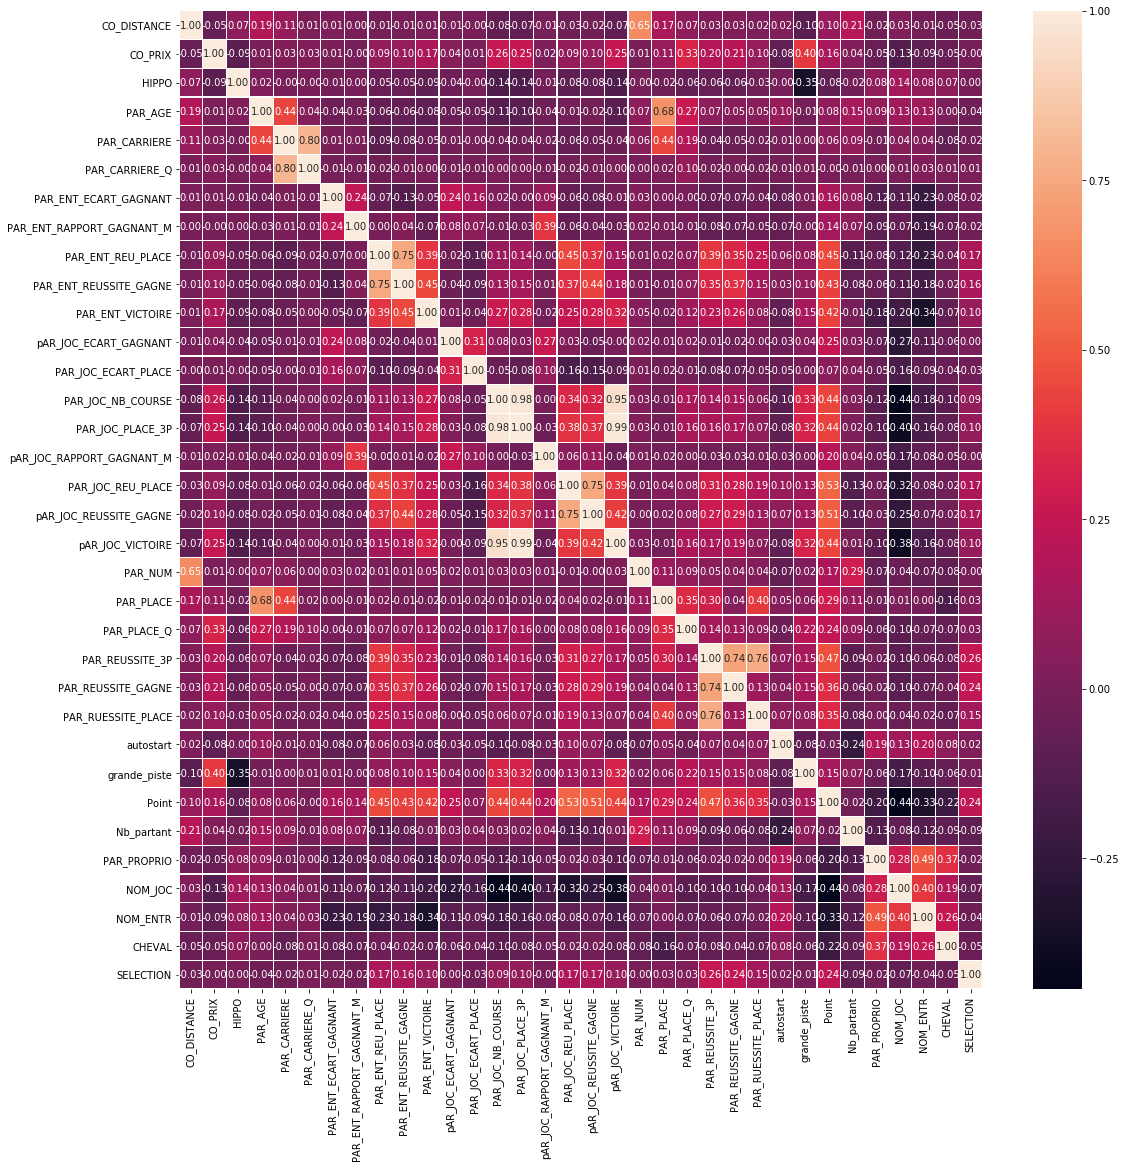

In [31]:
#Enfin, quelque chose de vraiment cool que vous pouvez mettre 

#dans une carte de chaleur est une matrice de corrélation. 
#Pandas DataFrame a une méthode corr qui calcule le coefficient de corrélation de Pearson (peut être un autre)
#entre tous les couples de colonnes numériques du DataFrame.

fig, ax = plt.subplots(figsize=(18,18))
sns.heatmap(df_gagnant.corr(), annot=True, fmt=".2f", linewidths=.2, ax=ax)


Proportion: 5.68 : 1
Total number of records : 266243 
Nombre de participations avec SELECTION = 0 : 226378
Nombre de participations avec SELECTION = 1  : 39865
Pourcentage 0: 85.0268%,  pourcentage 1 : 14.9732%


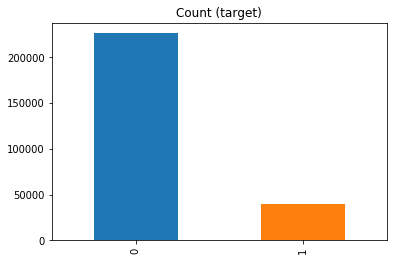

In [19]:
target_count = df_gagnant['SELECTION'].value_counts()


print('Proportion:', round(target_count[0] / target_count[1], 2), ': 1')
target_count.plot(kind='bar', title='Count (target)')

normal_trans_perc = sum(df_gagnant['SELECTION'] == 0) / (sum(df_gagnant['SELECTION'] == 0) + sum(df_gagnant['SELECTION'] == 1))
fraud_trans_perc = 1 - normal_trans_perc
print('Total number of records : {} '.format(len(df_gagnant)))
print('Nombre de participations avec SELECTION = 0 : {}'.format(sum(df_gagnant['SELECTION'] == 0)))
print('Nombre de participations avec SELECTION = 1  : {}'.format(sum(df_gagnant['SELECTION'] == 1)))
print('Pourcentage 0: {:.4f}%,  pourcentage 1 : {:.4f}%'.format(normal_trans_perc * 100,fraud_trans_perc * 100))




# Definition des set

In [43]:
from sklearn.model_selection import train_test_split

train_x, test_x, train_y, test_y = train_test_split(df_gagnant[feature_columns],
                                                     df_gagnant[response_column], test_size=0.33, random_state=42)
train_eval_X =  df_gagnant[feature_columns]
train_eval_Y=  df_gagnant[response_column]





print("Train_x",train_x.shape)
print("Train y",train_y.shape)
print("Test x",test_x.shape)
print("Test y",test_y.shape)

print("train_eval_X",train_eval_X.shape)
print("train_eval_Y",train_eval_Y.shape)

print("Test x",test_x.shape)
print("Test y",test_y.shape)

test_y = test_y['SELECTION'].ravel()
train_y = train_y['SELECTION'].ravel()



Train_x (178382, 33)
Train y (178382, 1)
Test x (87861, 33)
Test y (87861, 1)
train_eval_X (266243, 33)
train_eval_Y (266243, 1)
Test x (87861, 33)
Test y (87861, 1)


In [44]:
def smot2(train_x,train_y,feature_columns):

    from imblearn.combine import SMOTEENN
    from imblearn.over_sampling import SMOTE


    #print('\nOriginal dataset shape {}'.format(Counter(train_y)))
    sm = SMOTEENN(ratio='minority',n_jobs=3,random_state=42,n_neighbors=10,smote=SMOTE(ratio='minority',k_neighbors=100,n_jobs=3) )
    #sm = SMOTE(ratio='minority', n_jobs=3, random_state=42,m_neighbors=10)


    #log.traceLogInfo("\nFIT DE SMOT2 ...equilibrage")
    X_res, y_res = sm.fit_sample(train_x, train_y)

    print('\nResampled dataset shape {}'.format(Counter(y_res)))
    # reconstitution DATAFRAME
    train_x = pd.DataFrame(X_res, columns=feature_columns)
    train_y = pd.Series(y_res)
    print("Fin SMOT")



    return train_x,train_y

# ESTIMATEUR

In [45]:



#train_x, train_y = smot2(train_x=train_x, train_y=train_y, feature_columns=feature_columns)
#test_x, test_y = smot2(train_x=test_x, train_y=test_y, feature_columns=feature_columns)



In [46]:
 clf.predict_proba(test_x)[:, 1]

array([0.27, 0.75, 0.12, ..., 0.48, 0.82, 0.03])

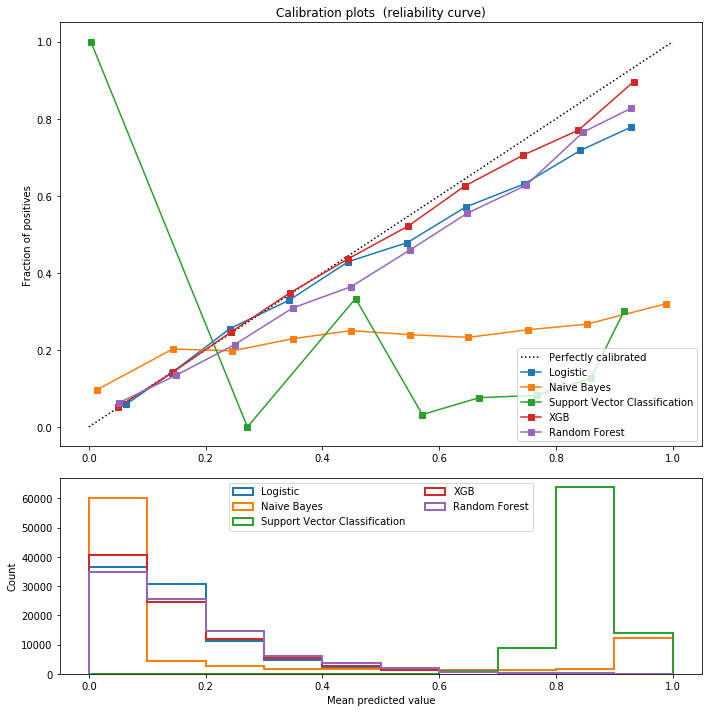

In [48]:
# Create classifiers
lr = LogisticRegression()
gnb = GaussianNB()
svc = LinearSVC(C=1.0)
rfc = RandomForestClassifier(n_estimators=100)
xgb= XGBClassifier( n_estimators=1800, n_jobs=2)




# #############################################################################
# Plot calibration plots

plt.figure(figsize=(10, 10))
ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
ax2 = plt.subplot2grid((3, 1), (2, 0))

ax1.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
for clf, name in [(lr, 'Logistic'),
                  (gnb, 'Naive Bayes'),
                  (svc, 'Support Vector Classification'),
                       (xgb, 'XGB'),
                  (rfc, 'Random Forest')]:
    clf.fit(train_x, train_y)
   #y_pred = clf.predict(test_x)
#  predictions = [round(value) for value in y_pred]
#  PROBA = model.predict_proba(test_
    
    
    if hasattr(clf, "predict_proba"):
        prob_pos = clf.predict_proba(test_x)[:, 1]
    else:  # use decision function
        prob_pos = clf.decision_function(test_x)
        prob_pos = (prob_pos - prob_pos.min()) / (prob_pos.max() - prob_pos.min())
        
    fraction_of_positives, mean_predicted_value = calibration_curve(test_y, prob_pos, n_bins=10)

    ax1.plot(mean_predicted_value, fraction_of_positives, "s-",label="%s" % (name, ))

    ax2.hist(prob_pos, range=(0, 1), bins=10, label=name,
             histtype="step", lw=2)

ax1.set_ylabel("Fraction of positives")
ax1.set_ylim([-0.05, 1.05])
ax1.legend(loc="lower right")
ax1.set_title('Calibration plots  (reliability curve)')

ax2.set_xlabel("Mean predicted value")
ax2.set_ylabel("Count")
ax2.legend(loc="upper center", ncol=2)

plt.tight_layout()
plt.show()